# GECCO Constraints on RH Neutrino

In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from matplotlib.ticker import LogLocator, NullFormatter

from hazma.parameters import (
    sv_inv_MeV_to_cm3_per_s,
    muon_mass as m_mu,
    charged_pion_mass as m_pi,
    neutral_pion_mass as m_pi0,
    electron_mass as m_e
)
from hazma import gamma_ray_parameters
from hazma.gamma_ray_parameters import *

from hazma.theory import TheoryDec
from hazma.rh_neutrino import RHNeutrino

import pickle

ImportError: dlopen(/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/rh_neutrino/_rh_neutrino_fsr_four_body.cpython-38-darwin.so, 2): Symbol not found: __ZSt20__throw_length_errorPKc
  Referenced from: /Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/rh_neutrino/_rh_neutrino_fsr_four_body.cpython-38-darwin.so
  Expected in: flat namespace
 in /Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/rh_neutrino/_rh_neutrino_fsr_four_body.cpython-38-darwin.so

In [2]:
mxs = np.logspace(-1, np.log10(500.0), 100)
model = RHNeutrino(mxs[0], 1e-3, "e", True)

## Tools

In [3]:
# Other constants
T_obs_nt = 1e6  # s
v_mw = 1e-3
x_kd = 1e-6  # DM mass divided by T_kd

In [4]:
# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)
# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}

In [5]:
# Base figure size
fig_dim = 4
mpl_colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [6]:
def get_constraints(
    model,
    mxs,
    nt_targets={},
    existing=["comptel", "egret", "fermi", "integral"],
    cmb=True
):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i in trange(len(mxs)):
        model.mx = mxs[i]

        # Constraints from existing data
        for telescope in existing:
            constraints[telescope][i] = model.binned_limit(eval(f"{telescope}_diffuse"))

        # Projections
        for key, (target, bg_model) in nt_targets.items():
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco,
                energy_res_gecco,
                T_obs_nt,
                target,
                bg_model,
            )

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("comptel", "COMPTEL")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("integral", "INTEGRAL ")
    label = label.replace("gecco_", "GECCO ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def plot_existing(ax, mxs, svs, label, color, y2=1):
    """
    Plots an existing constraint.
    """
    if label == r"CMB ($s$-wave)":
        ax.plot(mxs[fs], svs, "-.k", linewidth=1, label=label)
    elif label == r"CMB ($p$-wave)":
        v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
        ax.plot(
            mxs, svs * (v_mw / v_cmbs)**2, "--k", linewidth=1, label=label
        )
    else:
        ax.fill_between(mxs, svs, y2=y2, label=label, alpha=0.2, color=color)
        ax.loglog(mxs, svs, "-", color=color, linewidth=0.5)

# Global formatting
colors = {
    "comptel": mpl_colors[0],
    "egret": mpl_colors[1],
    "fermi": mpl_colors[2],
    "integral": mpl_colors[3],
    "gc_ein_1_arcmin_cone_optimistic": mpl_colors[4],
    "gc_ein_5_deg_optimistic": mpl_colors[4],
    "gc_nfw_1_arcmin_cone": mpl_colors[5],
    "gc_nfw_5_deg": mpl_colors[5],
    "m31_nfw_1_arcmin_cone": mpl_colors[6],
    "m31_nfw_5_deg": mpl_colors[6],
    "draco_nfw_1_arcmin_cone": mpl_colors[7],
    "draco_nfw_5_deg": mpl_colors[7],
}

linestyles = {
    "gc_ein_1_arcmin_cone_optimistic": "-",
    "gc_ein_5_deg_optimistic": "-",
    "gc_nfw_1_arcmin_cone": "--",
    "gc_nfw_5_deg": "--",
    "m31_nfw_1_arcmin_cone": ":",
    "m31_nfw_5_deg": ":",
    "draco_nfw_1_arcmin_cone": ":",
    "draco_nfw_5_deg": ":",
}

## Compute Constraints

In [7]:
constraints = get_constraints(model,mxs, nt_targets=nt_targets_dec)

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(


KeyboardInterrupt: 

In [8]:
constraints['telescopes'] = np.array([
    np.min([
        constraints['comptel'][i],
        constraints['egret'][i],
        constraints['fermi'][i],
        constraints['integral'][i]
    ])
    for i in range(len(mxs))
])

NameError: name 'constraints' is not defined

## Save/Load Data

In [7]:
""" Save the data
with open('../data/rh_neutrino.p', 'wb') as f:
    pickle.dump(constraints, f)
"""

#Load the data
constraints = None
with open('../data/rh_neutrino.p', 'rb') as f:
    constraints = pickle.load(f)


## Computing $\sin\theta$ from $\tau$ and $m_{\chi}$

In [8]:
def compute_stheta(mx, tau):
    mod = RHNeutrino(mx, 1e-3)
    
    def f(log_stheta):
        mod.stheta = 10.0**log_stheta
        # convert with to s^-1
        w = mod.decay_widths()['total'] * 1.52e24
        return 1.0 / w - tau
    
    root = root_scalar(f, bracket=(-30, 0))
    
    if root.converged:
        return 10**root.root
    else:
        return -1.0    

In [9]:
taus = np.geomspace(1e21, 1e28, 100)
sthetas = np.array([[compute_stheta(mx, tau) for tau in taus] for mx in mxs])

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/rh_neutrino/_rh_neutrino_widths.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  return -(GF ** 2 * mx ** 5 * qe ** 2 * smix ** 2 * (6 - 5 * smix ** 2) ** 2) / (


In [17]:
mod = RHNeutrino(mxs[0], sthetas[0,0])

In [18]:
mod.decay_widths()

{'pi l': 0.0,
 'pi0 nu': 0.0,
 'k l': 0.0,
 'nu pi pi': 0.0,
 'l pi pi0': 0.0,
 'nu nu nu': 6.5787708863584506e-46,
 'nu l l': 0.0,
 'nu g': 1.7648206259648863e-50,
 'nu g g': 2.866807100976439e-66,
 'total': 6.578947368421047e-46}

In [19]:
from hazma.parameters import GF

In [22]:
3*GF**2 * mod.mx**5 / (96.0 * np.pi**3) * mod.stheta**2

6.57877088635846e-46

In [24]:
GF**2 / (96.0*np.pi**3)

4.570443126997507e-26

## Plots

In [10]:
colors = ['#1f77b4', 
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']

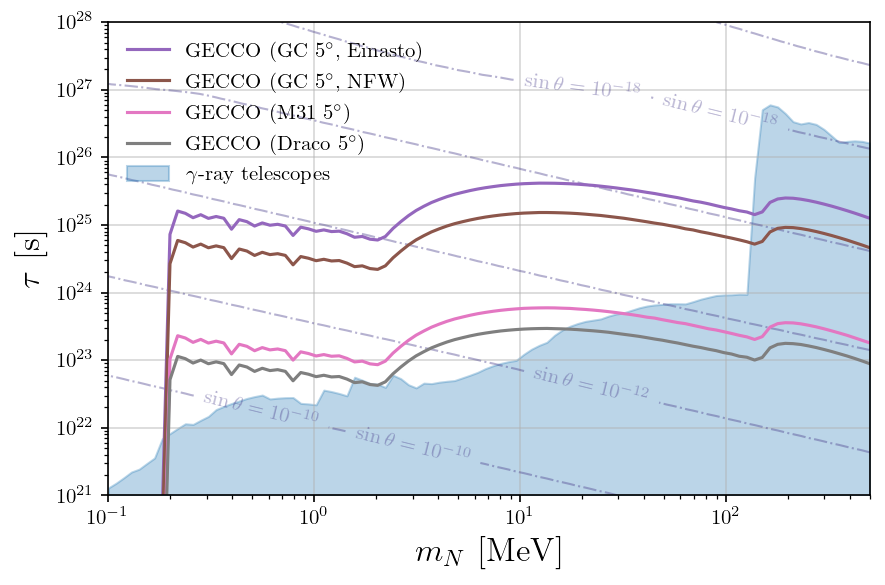

In [13]:
plt.figure(dpi=150)
ymin, ymax = [1e21, 1e28]

plt.yscale('log')
plt.xscale('log')

plt.fill_between(
    mxs, 
    y1=ymin,
    y2=1.0/constraints['telescopes'],  
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)



# for key in ['comptel', 'egret', 'fermi', 'integral']:
#    plt.plot(
#        mxs, 
#        1.0/constraints[key],  
#        #label=r'$\gamma$-ray telescopes',
#        linestyle="-",
#        color="grey",
#        alpha=0.5
#    )


plt.plot(
    mxs,     
    1.0/constraints['gecco_gc_ein_5_deg_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_5_deg_optimistic'),
    linestyle="-",
    color=colors[4],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_gc_nfw_5_deg'],  
    label=get_constraint_label('gecco_gc_nfw_5_deg'),
    linestyle="-",
    color=colors[5],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_m31_nfw_5_deg'],  
    label=get_constraint_label('gecco_m31_nfw_5_deg'),
    linestyle="-",
    color=colors[6],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_draco_nfw_5_deg'],  
    label=get_constraint_label('gecco_draco_nfw_5_deg'),
    linestyle="-",
    color=colors[7],
)


cs = plt.contour(
    mxs, 
    taus, 
    sthetas, 
    levels=[1e-20, 1e-18, 1e-16, 1e-14, 1e-12, 1e-10],
    alpha=0.4,
    colors="darkslateblue",
    linestyles="-.",
    linewidths=1
)

manual_locations = [(0.5, 5e21), (3, 5e21), (20, 1e22), (20, 1e27), (100, 1e27)]

plt.clabel(
    cs,
    fontsize=10,
    fmt={
        1e-20: r"$\sin\theta=10^{-20}$",
        1e-18: r"$\sin\theta=10^{-18}$",
        1e-16: r"$\sin\theta=10^{-16}$",
        1e-14: r"$\sin\theta=10^{-14}$",
        1e-12: r"$\sin\theta=10^{-12}$",
        1e-10: r"$\sin\theta=10^{-10}$",
    },
    use_clabeltext=True,
    colors="darkslateblue",
    rightside_up=True,
    inline=True,
    manual=manual_locations
)
    
    
plt.ylim([1e21, 1e28])
plt.xlim([np.min(mxs), np.max(mxs)])
plt.ylabel(r'$\tau \ [\mathrm{s}]$',fontsize=16)
plt.xlabel(r'$m_{N} \ [\mathrm{MeV}]$',fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.grid(alpha=0.5)
#plt.savefig('../figures/gecco_rh_neutrino.pdf')